### 1. 环境准备

In [2]:
from uu import encode
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install seaborn==0.13.2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

### 2. 数据处理

Pandas 数据类型 旧版Pandas（包括本演示中用的版本）只有数值型和Object 类型  
新版本还加入了String类型以提高对string的操作性能



In [40]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
data = pd.read_csv(file_path)
print(data.shape, set(data.dtypes)) #可以看到只有object和float64两种类型，O=object
data.head()

(2111, 17) {dtype('O'), dtype('float64')}


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


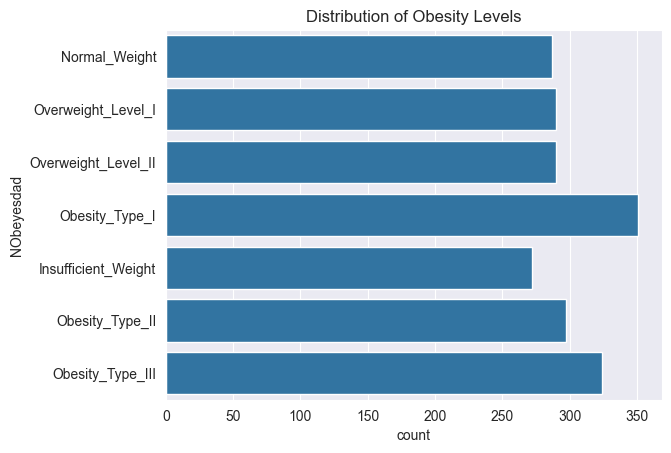

In [4]:
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribution of Obesity Levels')
plt.show()

In [ ]:
print(data.isnull().sum())
print(data.info())
print(data.describe())

对continuous_columns 几个数值列做z-score标准化

In [39]:
print(data.shape)
# 挑选出数据类型是 float64 的列（通常是连续数值特征）
continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()
print(continuous_columns)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continuous_columns]) #Z-score 标准化

# Converting to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

# 删除原数据集中的continuous_columns，再和scaled_df拼接
scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)
print(scaled_data.shape)
print(scaled_data.columns)

(2111, 17)
['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
(2111, 17)
Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad', 'Age', 'Height', 'Weight',
       'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'],
      dtype='object')


One-HOT 编码：将分类特征 转化为 数据特征。 具体做法是把某一列的n个特征 拆分成N-1列，列值为0或1.  
‼️ 有个细节：n个特征被拆分成了N-1列，也就是只需要构建N-1个二分类器  
如：性别，只需要构建一个二分类器 识别是否是男就可以。 像红黄蓝三色特征，也就需要构建识别蓝色和红色二分类器。

In [20]:
# Identifying categorical columns
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad') # 移除目标列Y

# One-Hot编码：将非数值类特征（特别是分类类别）转化成数值特征
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

# Converting to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Combining with the original dataset
prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)
print(encoded_df.shape, prepped_data.shape)
encoded_df.head()

(2111, 15) (2111, 24)


,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [16]:
prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
prepped_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [21]:
X = prepped_data.drop('NObeyesdad', axis=1)
y = prepped_data['NObeyesdad']

### 3. 模型训练

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

在逻辑回归模型训练时，会使用梯度下降算法 迭代训练 以逼近最优解  
LogisticRegression(max_iter=1000)
- maximum iterations 最大迭代次数 ： 最大允许迭代多少次

In [28]:
from sklearn.multiclass import OneVsRestClassifier
# 使用 1v所有 策略：
model_ova = OneVsRestClassifier(LogisticRegression(max_iter=1000), n_jobs=-1) 
model_ova.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000), n_jobs=-1)

In [32]:
y_pred_ova = model_ova.predict(X_test)

# Evaluation metrics for OvA
print("One-vs-All (OvA) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ova),2)}%")

One-vs-All (OvA) Strategy
Accuracy: 76.12%


### 4. 模型评估

In [36]:
coefs = np.array([est.coef_[0] for est in model_ova.estimators_])
print(coefs.shape)
coefs # coefs 中存放的是 逻辑回归模型的权重参数

(7, 23)


array([[-5.32857309e-01,  2.13242083e+00, -8.16366657e+00,
         3.22105759e-01,  1.06603962e-01,  2.07378505e-01,
        -8.27843283e-02,  1.31655111e-01, -5.13388645e-01,
        -1.68411932e-01, -2.91422788e-01,  1.19845514e+00,
         7.14810701e-01,  3.48022195e-01, -7.47751970e-01,
        -2.69459556e-01, -4.18174717e-01,  2.21184193e-01,
         1.98027526e-01, -7.46571358e-01, -2.30398838e-01,
         1.15351158e-01, -5.07643251e-01],
       [-1.97205885e-01, -6.81339397e-02, -1.56892303e+00,
        -1.66285548e-01, -4.75945995e-03, -2.57154384e-01,
         2.32062429e-01, -1.76495906e-01,  9.40909158e-01,
        -1.93080610e-01, -9.53641704e-02, -1.05851846e+00,
        -1.68704478e+00, -1.48981893e+00,  1.04049237e+00,
         1.60822585e-01,  5.99543270e-01, -5.71662478e-01,
        -4.98339252e-01,  1.08992371e+00,  1.06417514e+00,
        -3.04338622e-01,  1.42240239e+00],
       [-1.81982262e-01, -7.63411764e-01,  8.55631704e-01,
        -7.98272876e-01, -3.4

Feature Importance 图 的确是用来表示 每个特征对预测结果的影响大小  
直方图中，数值越大的特征对结果影响越大， 可见体重和性别对是否肥胖的分类影响最大

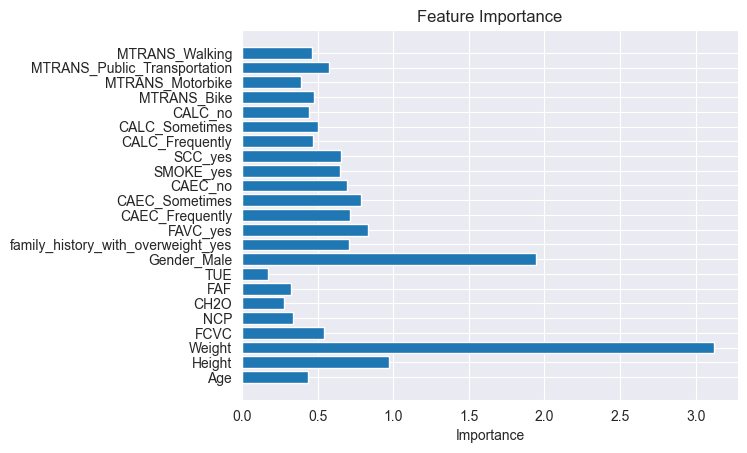

In [38]:
feature_importance = np.mean(np.abs(coefs),axis=0)
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

### 5. 完整代码


In [ ]:

# write your function here and then execute this cell
def obesity_risk_pipeline(data_path, test_size):
    # down data
    data = pd.read_csv(data_path)
    # float type 的数据 z-score标准化
    float_col_name_list = data.select_dtypes(include=['float64']).columns.to_list()
    scaler = StandardScaler()
    float_np_cols = scaler.fit_transform(data[float_col_name_list])  # 输入pandas，输出是一个numpy
    float_pd_cols = pd.DataFrame(float_np_cols, columns=scaler.get_feature_names_out(float_col_name_list))
    total_data_after_scales = pd.concat([float_pd_cols, data.drop(columns=float_col_name_list)], axis=1)

    # object字段 one-hot编码
    obj_col_names = data.select_dtypes(include=['object']).columns.to_list()
    obj_col_names.remove('NObeyesdad')

    encoder = OneHotEncoder(sparse_output=False, drop='first')
    obj_np_cols = encoder.fit_transform(data[obj_col_names])
    obj_onehot_df_data = pd.DataFrame(obj_np_cols, columns=encoder.get_feature_names_out(obj_col_names))

    total_processed_data = pd.concat([total_data_after_scales.drop(columns=obj_col_names), obj_onehot_df_data], axis=1)

    # train
    X = total_processed_data.drop('NObeyesdad', axis=1)
    y = total_processed_data['NObeyesdad']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
    model_ovo.fit(X_train, y_train)
    # evaluate
    y_pred = model_ovo.predict(X_test)
    return accuracy_score(y_test, y_pred)
